# Outline

### This notebook contains general data analysis for the given problem. <br>
### Content:
1. Determining phosphorylation sites
2. Secondary structure analysis
3. Dropping unrelevant features
4. Grouping proteins
5. Introducing EPSD data (sequences of proteins)
6. Merging the EPSD data
7. Determining the pos_weight for training
8. Merging with PESTO files
9. Filtering inconsistencies between PESTO and EPSD
10. Crafting train and test sets
11. Aditional analysis

# Data Analysis and preprocessing

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from Bio import SeqIO
import utils
import glob
import re

Load the first version of the data

In [2]:
# Load data
data = pd.read_csv("data/phos_clean_v01.csv").set_index('EPSD ID')
data

,original_index,UniProt ID,AA,Position,Source,Reference,ss,conf_i0,coor_x,coor_y,coor_z,afold_conf_mask
EPSD ID,,,,,,,,,,,,
EP0096278,0,A0A021WW64,S,159,Exp.,27794539,C,0.11,29.878000,-8.869000,5.408000,1
EP0096278,1,A0A021WW64,S,173,Exp.,27794539; 21082442; 19060867; 30418626,C,0.01,15.855000,-2.874000,-17.785000,1
EP0096278,2,A0A021WW64,T,201,Exp.,19429919; 21082442; 21081558; 19060867; 228179...,H,0.65,-6.583000,3.583000,2.275000,1
EP0096278,3,A0A021WW64,S,207,Exp.,19060867; 30418626; 21082442,H,0.69,-13.166000,6.673000,8.861000,1
EP0096280,5,A0A023GRW3,S,186,Exp.,22817900; 19366988; 18327897; 30418626; 24705204,C,0.00,55.398998,36.817001,4.155000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
EP0209266,1616597,X5M5W2,S,956,Exp.,28854356,H,0.02,72.547997,-19.377001,12.371000,1
EP0209284,1616649,X6R8D5,S,24,Exp.,17929957,C,0.87,40.007999,4.843000,-10.467000,0
EP0209284,1616650,X6R8D5,S,27,Exp.,17929957,C,0.06,36.835999,7.712000,-18.806999,0


## 1. Determining the phosphorylation sites

In most scenarios Phosphorelation can happen only on three sites (S, T, Y) which is also true for this dataset

In [3]:
# Determining phosphorylation sites
data.AA.unique()

array(['S', 'T', 'Y'], dtype=object)

How common is which amino acid for Phosphorelation?

<AxesSubplot:>

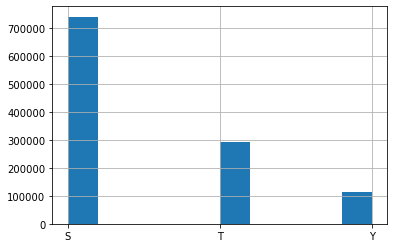

In [4]:
# Plotting histogram
data['AA'].hist()

## 2. Secondary structure analysis

In this data there are only three types of secondary structures

In [5]:
# Extraction of all possible ss
data.ss.unique()

array(['C', 'H', 'E'], dtype=object)

<AxesSubplot:>

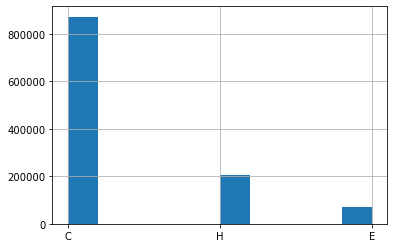

In [6]:
# Plottin histogram
data['ss'].hist()

## 3. Dropping unrelevant features

The initial training will only use the sequence feature.
We cannot use secondary structure, conf_i0 and afold_cond_mask as features because in this dataset they were only applied to the outputs

In [7]:
# Preserve relevant columns
data = data[['UniProt ID', 'AA', 'Position']]
data

,UniProt ID,AA,Position
EPSD ID,,,
EP0096278,A0A021WW64,S,159
EP0096278,A0A021WW64,S,173
EP0096278,A0A021WW64,T,201
EP0096278,A0A021WW64,S,207
EP0096280,A0A023GRW3,S,186
...,...,...,...
EP0209266,X5M5W2,S,956
EP0209284,X6R8D5,S,24
EP0209284,X6R8D5,S,27


At the current the data does not include the sequence feature which should be extracted from the ```epsd_total.fasta``` file

## 4. Grouping proteins

In [8]:
# List-aggregation of the data
data = data.groupby(['EPSD ID', 'UniProt ID']).agg(list)
data.reset_index(level=1, inplace=True)
data

,UniProt ID,AA,Position
EPSD ID,,,
EP0000001,O00087,"[T, S, S, S]","[138, 139, 206, 207]"
EP0000002,O00091,"[S, S, S, S]","[163, 485, 498, 53]"
EP0000004,O00103,"[S, S]","[17, 18]"
EP0000005,O00110,"[S, Y, T, T, S, S, S]","[117, 29, 36, 49, 54, 69, 86]"
EP0000006,O00115,"[Y, S, Y, S, S]","[20, 355, 358, 41, 70]"
...,...,...,...
EP0209260,X5LPS1,"[T, S]","[19, 21]"
EP0209262,X5LV34,[S],[166]
EP0209265,X5M5N0,"[T, S, S, S, S, S, T, T, S, S, S]","[1069, 1076, 1091, 1094, 1598, 1599, 1603, 160..."


In [9]:
# Counting the number of phosphorylation sites per protein
data['phos_site_cnt'] = data['AA'].apply(len)
data

,UniProt ID,AA,Position,phos_site_cnt
EPSD ID,,,,
EP0000001,O00087,"[T, S, S, S]","[138, 139, 206, 207]",4
EP0000002,O00091,"[S, S, S, S]","[163, 485, 498, 53]",4
EP0000004,O00103,"[S, S]","[17, 18]",2
EP0000005,O00110,"[S, Y, T, T, S, S, S]","[117, 29, 36, 49, 54, 69, 86]",7
EP0000006,O00115,"[Y, S, Y, S, S]","[20, 355, 358, 41, 70]",5
...,...,...,...,...
EP0209260,X5LPS1,"[T, S]","[19, 21]",2
EP0209262,X5LV34,[S],[166],1
EP0209265,X5M5N0,"[T, S, S, S, S, S, T, T, S, S, S]","[1069, 1076, 1091, 1094, 1598, 1599, 1603, 160...",11


## 5. Introducing EPSD data (sequences of proteins)

In [10]:
# Loading and parsing fasta file
epsd_data = pd.DataFrame([
                            {
                                'EPSD ID' : record.id.split('|')[0],
                                'seq' : np.array(record.seq)
                            } 
                            for record in SeqIO.parse("data/epsd_total.fasta", "fasta")
                        ])

# Counting total length of AA sequence
epsd_data['seq_len'] = epsd_data['seq'].apply(len)

# Converting sequnce to integer-array
epsd_data['seq'] = epsd_data['seq'].apply(utils.aa_seq_to_ord)

print(epsd_data)

          EPSD ID                                                seq  seq_len
0       EP0000001  [12, 10, 2, 15, 19, 9, 11, 1, 15, 0, 10, 4, 1,...      511
1       EP0000002  [12, 15, 15, 0, 2, 10, 15, 9, 11, 6, 2, 7, 0, ...      500
2       EP0000003  [12, 15, 19, 14, 16, 16, 5, 11, 0, 19, 19, 13,...      348
3       EP0000004  [12, 3, 15, 3, 12, 5, 2, 5, 2, 14, 8, 16, 2, 1...      176
4       EP0000005  [12, 14, 1, 0, 13, 10, 19, 1, 15, 1, 1, 14, 5,...      214
...           ...                                                ...      ...
209321  EP0209322  [12, 16, 7, 15, 14, 11, 10, 13, 14, 15, 14, 7,...      263
209322  EP0209323  [12, 0, 3, 16, 14, 15, 19, 18, 6, 16, 1, 13, 6...      484
209323  EP0209324  [10, 9, 0, 11, 19, 3, 6, 10, 16, 4, 6, 11, 3, ...      901
209324  EP0209325  [12, 0, 3, 16, 14, 15, 19, 18, 6, 16, 1, 13, 6...       52
209325  EP0209326  [6, 12, 15, 10, 15, 7, 10, 3, 2, 15, 11, 10, 6...      350

[209326 rows x 3 columns]


### Long list problem
If the list of residues is very long (over a thousand elements) when written to a file it is done in a truncated fashion (\[ 1,2, ... ,5 ,6\]) which is not very useful as a dataset <br>
To adress this issue we convert the ndarray into a string

In [11]:
# Converting array ot string
def list_to_str(seq):
    s = '['
    for i in seq:
        s += str(i)
        s += ' '
    s += ']'
    return s
epsd_data['seq'] = epsd_data['seq'].apply(list_to_str)

## 6. Merging the EPSD data

In [12]:
# Merging EPSD data
data = data.merge(epsd_data, how='inner', on='EPSD ID')
data

,EPSD ID,UniProt ID,AA,Position,phos_site_cnt,seq,seq_len
0,EP0000001,O00087,"[T, S, S, S]","[138, 139, 206, 207]",4,[12 10 2 15 19 9 11 1 15 0 10 4 1 13 11 13 16 ...,511
1,EP0000002,O00091,"[S, S, S, S]","[163, 485, 498, 53]",4,[12 15 15 0 2 10 15 9 11 6 2 7 0 12 19 19 13 7...,500
2,EP0000004,O00103,"[S, S]","[17, 18]",2,[12 3 15 3 12 5 2 5 2 14 8 16 2 15 11 2 15 15 ...,176
3,EP0000005,O00110,"[S, Y, T, T, S, S, S]","[117, 29, 36, 49, 54, 69, 86]",7,[12 14 1 0 13 10 19 1 15 1 1 14 5 14 14 2 17 7...,214
4,EP0000006,O00115,"[Y, S, Y, S, S]","[20, 355, 358, 41, 70]",5,[12 9 14 10 10 10 0 0 10 10 4 19 14 0 7 0 10 1...,360
...,...,...,...,...,...,...,...
103686,EP0209260,X5LPS1,"[T, S]","[19, 21]",2,[12 7 3 1 15 19 3 6 14 0 19 7 4 15 3 3 0 6 16 ...,801
103687,EP0209262,X5LV34,[S],[166],1,[12 5 16 7 1 14 14 14 13 13 11 5 12 8 18 14 8 ...,861
103688,EP0209265,X5M5N0,"[T, S, S, S, S, S, T, T, S, S, S]","[1069, 1076, 1091, 1094, 1598, 1599, 1603, 160...",11,[12 14 3 15 9 16 2 7 7 1 14 14 0 14 14 15 15 1...,1850
103689,EP0209266,X5M5W2,"[T, S, S, S, S, T, S, S, T, S, S, S, S, S, T, ...","[1028, 1029, 1030, 1031, 1037, 1039, 1065, 106...",19,[12 6 3 11 16 15 11 6 11 6 11 15 0 3 11 1 9 3 ...,2318


## 7. Determining the pos_weight for training

1. CNN model

Calculating pos_weight as ratio of total number of AA in sequnces and total number of phosphorylation sites.

In [13]:
# Determining positive weight for BCloss for CNN model
np.sum(data['seq_len'])/np.sum(data['phos_site_cnt'])

51.85764939547485

2. Linear model

In [14]:
# Determining positive weight for BCloss for Linear model
def count_STY(seq):
    '''
    Count number of possible phosphorelations in a protein w.r.t AA
    
    Parameters
    ----------
    seq : pd.Series
        sequence of AA
    
    Returns
    -------
    int
        Number of AA where phosphoreation may occurr
    '''
    seq = re.findall(r'\d+', seq)
    seq = list(map(int, seq))
    count_S = (np.array(seq) == utils.aa_to_ord('S')).sum()
    count_T = (np.array(seq) == utils.aa_to_ord('T')).sum()
    count_Y = (np.array(seq) == utils.aa_to_ord('Y')).sum()
    return count_S + count_T + count_Y

# Counting total number of AA where phosphorelation may occurr 
total_count = data.seq.apply(count_STY).sum()
print('Total number of [S T Y] AAs : %d' % total_count)

# Counting total number of phosphorelations
ph_count = data.phos_site_cnt.sum()
print('Total number of phosphorelations : %d' % ph_count)

# Calculating ratio
ratio = ph_count / total_count
print('Ratio : %.5lf' % ratio)

Total number of [S T Y] AAs : 10002126
Total number of phosphorelations : 1146437
Ratio : 0.11462


## 8. Merging with PESTO files


In [14]:
# Creating datafrme of PESTO filenames
prot_files = pd.DataFrame({'file' : glob.glob('data/states/*')})

# Extracting UniProt ID from filename
prot_files['UniProt ID'] = prot_files['file'].apply(lambda x : re.search(r'AF-(\w+)-F\d+-model_v1.npy', x).group(1))
prot_files

,file,UniProt ID
0,data/states/AF-A0A060CYX6-F1-model_v1.npy,A0A060CYX6
1,data/states/AF-A0A021WW64-F1-model_v1.npy,A0A021WW64
2,data/states/AF-A0A060CYS6-F1-model_v1.npy,A0A060CYS6
3,data/states/AF-A0A023GRW3-F1-model_v1.npy,A0A023GRW3
4,data/states/AF-A0A060CYZ5-F1-model_v1.npy,A0A060CYZ5
...,...,...
340038,data/states/AF-X5M5Y4-F1-model_v1.npy,X5M5Y4
340039,data/states/AF-X5M8U1-F1-model_v1.npy,X5M8U1
340040,data/states/AF-X5ML99-F1-model_v1.npy,X5ML99
340041,data/states/AF-X6R8D5-F1-model_v1.npy,X6R8D5


In [15]:
# Merging EPSD and PESTO
data = data.merge(prot_files, how='inner', on='UniProt ID')
data

,EPSD ID,UniProt ID,AA,Position,phos_site_cnt,seq,seq_len,file
0,EP0000001,O00087,"[T, S, S, S]","[138, 139, 206, 207]",4,[12 10 2 15 19 9 11 1 15 0 10 4 1 13 11 13 16 ...,511,data/states/AF-O00087-F1-model_v1.npy
1,EP0000002,O00091,"[S, S, S, S]","[163, 485, 498, 53]",4,[12 15 15 0 2 10 15 9 11 6 2 7 0 12 19 19 13 7...,500,data/states/AF-O00091-F1-model_v1.npy
2,EP0000004,O00103,"[S, S]","[17, 18]",2,[12 3 15 3 12 5 2 5 2 14 8 16 2 15 11 2 15 15 ...,176,data/states/AF-O00103-F1-model_v1.npy
3,EP0000005,O00110,"[S, Y, T, T, S, S, S]","[117, 29, 36, 49, 54, 69, 86]",7,[12 14 1 0 13 10 19 1 15 1 1 14 5 14 14 2 17 7...,214,data/states/AF-O00110-F1-model_v1.npy
4,EP0000006,O00115,"[Y, S, Y, S, S]","[20, 355, 358, 41, 70]",5,[12 9 14 10 10 10 0 0 10 10 4 19 14 0 7 0 10 1...,360,data/states/AF-O00115-F1-model_v1.npy
...,...,...,...,...,...,...,...,...
103119,EP0209260,X5LPS1,"[T, S]","[19, 21]",2,[12 7 3 1 15 19 3 6 14 0 19 7 4 15 3 3 0 6 16 ...,801,data/states/AF-X5LPS1-F1-model_v1.npy
103120,EP0209262,X5LV34,[S],[166],1,[12 5 16 7 1 14 14 14 13 13 11 5 12 8 18 14 8 ...,861,data/states/AF-X5LV34-F1-model_v1.npy
103121,EP0209265,X5M5N0,"[T, S, S, S, S, S, T, T, S, S, S]","[1069, 1076, 1091, 1094, 1598, 1599, 1603, 160...",11,[12 14 3 15 9 16 2 7 7 1 14 14 0 14 14 15 15 1...,1850,data/states/AF-X5M5N0-F1-model_v1.npy
103122,EP0209266,X5M5W2,"[T, S, S, S, S, T, S, S, T, S, S, S, S, S, T, ...","[1028, 1029, 1030, 1031, 1037, 1039, 1065, 106...",19,[12 6 3 11 16 15 11 6 11 6 11 15 0 3 11 1 9 3 ...,2318,data/states/AF-X5M5W2-F1-model_v1.npy


## 9. Filtering inconsistencies between PESTO and EPSD

In [16]:
# Filtering proteins whose sequnce length in EPSD and PESTO do not match
def bad_pesto_flag(x):
    with open(x.file, 'rb') as f:
        num = np.load(f).shape[0]
    return num == x.seq_len

# Extract indicator if information in both datasets match
mask = data.apply(bad_pesto_flag, axis=1)

# Filter non-matching data
data = data[mask]

### Saving the new data

In [17]:
# Writting to file
data.to_csv('./data/merged_data_v2.tsv', sep='\t')

## 10. Crafting train and test sets

In [18]:
# Setting random seed to specific value
np.random.seed(1234)

# Creating mask used for splitting
mask = np.concatenate([np.ones(int(0.8 * data.shape[0])+1, dtype=bool), np.zeros(int(0.2 * data.shape[0]), dtype=bool)])
np.random.shuffle(mask)

# Splitting and saving to files
data[mask].to_csv('./data/merged_data_train_v2.tsv', sep='\t')
data[~mask].to_csv('./data/merged_data_test_v2.tsv', sep='\t')

## 11. Aditional analysis
### - Cutting off long sequences **(obsolete)**
**This part is now obsolete since the given data filtered out all of the extra long chains (i.e. the ESPD included chains as long as 35k amino acids which could have posed a problem for padding)**.

What is the longest sequence?

In [19]:
# Calculating max distance
epsd_data['seq_len'].max()

35991

Text(0.5, 1.0, 'Sequence length')

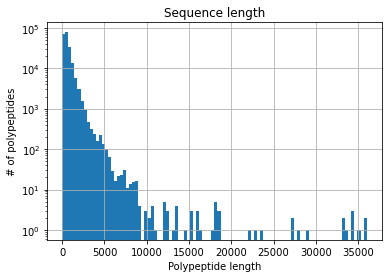

In [20]:
# Plotting historam of sequence length
epsd_data.seq_len.hist(bins=100, log=True,)
plt.xlabel('Polypeptide length')
plt.ylabel('# of polypeptides')
plt.title('Sequence length')

Though some proteins might be very long they are very few. If we were to work with shorter sequences where should be cut it off.

In [21]:
# Determining the cut-offs
cut_offs = np.array([np.sum(epsd_data['seq_len'] < x)/epsd_data.shape[0] for x in range(100, 36000, 100)])

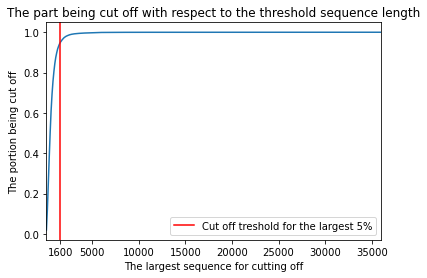

In [22]:
# Plotting graph w.r.t. cut-off
CUT_OFF = 0.05 # The portion of the largest sequence we want to cut off
plt.plot(range(100, 36000, 100), cut_offs)
tresh = (np.sum(cut_offs < (1. - CUT_OFF))+1)*100
plt.axvline(tresh, color='r', label='Cut off treshold for the largest %d%%' % int(CUT_OFF * 100))
plt.xticks(list(plt.xticks()[0][2:]) + [tresh])
plt.xlim(100, 36000)
plt.ylabel('The portion being cut off')
plt.xlabel('The largest sequence for cutting off')
plt.title('The part being cut off with respect to the threshold sequence length')
plt.legend()